## Clone GitHub Repo

In [ ]:
!git clone https://github.com/AntoineBernigaud/Neccton_Super_Resolution.git
%cd Neccton_Super_Resolution/

Cloning into 'Neccton_Super_Resolution'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 63 (delta 21), reused 29 (delta 7), pack-reused 0
Receiving objects: 100% (63/63), 3.00 MiB | 21.48 MiB/s, done.
Resolving deltas: 100% (21/21), done.


## Donwload the data:
- High resolution fields for validation
- Low resolution upsampled fields as an input of the neural network
- The High resolution land mask
- The weights of the NN

In [ ]:
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/LR_upsampled/restart.2015_004_00_0000.a -P data/LR_upsampled/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/LR_upsampled/restart.2015_004_00_0000.b -P data/LR_upsampled/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/residuals/restart.2015_004_00_0000.a -P data/Residuals/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/residuals/restart.2015_004_00_0000.b -P data/Residuals/

!wget -nc ftp://ftp.nersc.no/reddaml/neccton/residuals/tp5mask.npy -P data/Residuals/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/Model_weights/Checkpoints.h5 -P Weights/

--2024-03-13 12:15:27--  ftp://ftp.nersc.no/reddaml/neccton/HR/restart.2015_004_00_0000.a
           => ‘/content/drive/MyDrive/NECCTON/Neccton_Super_Resolution/data/HR/restart.2015_004_00_0000.a’
Resolving ftp.nersc.no (ftp.nersc.no)... 158.37.60.245
Connecting to ftp.nersc.no (ftp.nersc.no)|158.37.60.245|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /reddaml/neccton/HR ... done.
==> SIZE restart.2015_004_00_0000.a ... 1254785024
==> PASV ... done.    ==> RETR restart.2015_004_00_0000.a ... done.
Length: 1254785024 (1.2G) (unauthoritative)

restart.2015_004_00 100%[===================>]   1.17G  8.48MB/s    in 2m 52s  

2024-03-13 12:18:20 (6.97 MB/s) - ‘/content/drive/MyDrive/NECCTON/Neccton_Super_Resolution/data/HR/restart.2015_004_00_0000.a’ saved [1254785024]

--2024-03-13 12:18:20--  ftp://ftp.nersc.no/reddaml/neccton/HR/restart.2015_004_00_0000.b
           => ‘/content/drive/MyDrive/NECCTON/Nec

## Install necessary dependancies

In [ ]:
!pip install netCDF4==1.5.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00


## Import the necessary modules and define plot functions

In [ ]:
import os
from data_generator3V2 import Data_generator, generate_dates, convert_date_format, \
                            load_standardization_data
from models.attention_res_net3V2 import Att_Res_UNet
import tensorflow as tf
import re
import numpy as np
import numpy.ma as ma
import abfile
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%load_ext autoreload


def extract_name_and_number(input_string):
    """
    Extracts the name and number from a string in a specific format.
    (Used to get the name and layer number of a predictor out of a list of predictors).
    Args:
        input_string (str): The input string to be processed.

    Returns:
        tuple or None: A tuple containing the extracted name and number,
        or (None, None) if the input string doesn't match the expected format.
    """
    # Define a pattern for the desired format
    pattern = re.compile(r'^(.+)-(layer|cat)-(\d+)$')

    # Match the pattern against the input string
    match = pattern.match(input_string)

    # Check if the pattern matches
    if match:
        # Extract the name and number from the matched groups
        name = match.group(1)
        number = match.group(3)
        return name, number
    else:
        # Return None if the input string doesn't match the expected format
        return None, None



def plot_fld(vname,fld,max_abs_val = None, min_abs_val = None):
    """
    Plot field data

    Args:
        vname (str): The name of the variable being plotted.
        fld (numpy.ndarray): The field data to be plotted.
        max_abs_val (float, optional): The maximum absolute value for color scale.
            If None, maximum absolute value in `fld` is used. Defaults to None.
        min_abs_val (float, optional): The minimum absolute value for color scale.
            If None, minimum absolute value in `fld` is used. Defaults to None.
    Returns:
        None
    """
    f, (ax1) = plt.subplots(1, 1, figsize=(11, 11))
    if (max_abs_val is None) and (min_abs_val is None):
        max_abs_val = np.max(fld)
        min_abs_val = np.min(fld)
    P=ax1.pcolormesh(fld, vmin=min_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

cmap = plt.cm.get_cmap("bwr").copy()
cmap.set_bad('gray')
def plot_res(vname,fld,max_abs_val = None) :
    """
    Plot residual data with a red/white/blue centered at 0 color colorbar.

    Args:
        vname (str): The name of the variable being plotted.
        fld (numpy.ndarray): The field data to be plotted.
        max_abs_val (float, optional): The maximum absolute value for color scale.
            If None, maximum absolute value in `fld` is used. Defaults to None.
    Returns:
        None
    """
    f, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
    if max_abs_val is None:
        max_abs_val = np.max(np.abs(fld))
    P = ax1.pcolormesh(fld, cmap=cmap, vmin=-max_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

<ipython-input-7-81526b1aa72c>:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("bwr").copy()


## Define the dates to perform the super resolution and define the path to access the data

In [ ]:
# Minimum and maximum date to perform the super-resolution
date_min_test = '2015_004'
date_max_test = '2015_004'

days_range = 7 # number of days between two predictions
dates_test = generate_dates(date_min_test, date_max_test, days_range)
print('date list of testing days:')
print(dates_test)
print(f'number of testing days: {len(dates_test)}')

# Define the path for the data
paths = {}
root_data_dir = 'data'
# Path to the low resolution upsampled data and residuals data
paths["data_residuals"] = os.path.join(root_data_dir,"residuals")
paths["data_LR_upsampled"] = os.path.join(root_data_dir,"LR_upsampled")
# Path to the standardization files containing the mean / variance of the field
# for normalization
paths["standard"] = root_data_dir
file_standardization_res = os.path.join(paths["standard"],"standard_residuals.h5")
file_standardization_LR_upsampled = os.path.join(paths["standard"],"standard_LR_upsampled.h5")

# Path for the model weights
paths["model_weights"] = 'Weights/'
file_model_weights = os.path.join(paths["model_weights"],"Checkpoints.h5")

date list of testing days:
['2015_004']
number of testing days: 1


## Define the Predictors and the parameters for the test

In [ ]:
# Load standardization files
standard_LR_upsampled = load_standardization_data(file_standardization_LR_upsampled)
standard_res = load_standardization_data(file_standardization_res)

# the predictors must have the name "fieldname-layer-layernumber", except for the land
# mask called "tp5_mask"
list_predictors = ["temp-layer-1", "temp-layer-2", "temp-layer-3", "temp-layer-4", "temp-layer-5",
                    "temp-layer-6", "temp-layer-7", "temp-layer-8", "temp-layer-9", "temp-layer-10",
                    "tp5_mask"]
list_targets = ["temp-layer-1"]

# Model Parameters
model_params = {"list_predictors": list_predictors,
                "list_targets": list_targets,
                "dim": (760, 800), # (jdm,idm)
                "cropped_dim": (768, 800), #
                "batch_size": 1,
                "n_filters": [32*(i+1) for i in range(6)],
                "activation": "relu",
                "kernel_initializer": "he_normal",
                "batch_norm": True,
                "pooling_type": "Average",
                "dropout": 0,
               }
# Testing Parameters
params_test = {"list_predictors": model_params["list_predictors"],
                "list_labels": model_params["list_targets"],
                "list_dates": dates_test,
                "standard_res": standard_res,
                "standard_LR_upsampled": standard_LR_upsampled,
                "batch_size": model_params["batch_size"],
                "path_forcings": paths["forcings"],
                "path_data_res": paths["data_residuals"],
                "path_data_LR_upsampled": paths["data_LR_upsampled"],
                "dim": model_params["dim"],
                "cropped_dim": model_params["cropped_dim"],
                "shuffle": False,
                "res_normalization":1,
                }
#
model_and_compile_params = {**model_params, **params_test}

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/standard_LR_upsampled.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Initialize the Neural Network

In [ ]:
# Initialization of the data generator (used to load the data dynamically into the memory)
# and of the Neural network
test_generator = Data_generator(**params_test)
unet_model = Att_Res_UNet(**model_params).make_unet_model()
unet_model.load_weights(file_model_weights)

## Prediction of the HR field

In [ ]:
# Prediction on the first element of the first batch
predict_batch = unet_model.predict(test_generator[0][0]) # prediction on test_generator['batch_number']['LR field upsampled']

# Choose a target number (for now only possible to choose the only target number 0)
target_no = 0
target_name, target_layer = extract_name_and_number(list_targets[target_no])
target_layer = int(target_layer)
# Get the field corresponding to the chosen target in the prediction
predict = predict_batch[0,:,:,target_no]
# Crop the prediction to match the dimension of the real field
predict = predict[0:760,:]
# Same thing for the input (X) and the truth (y)
X_batch, y_batch = test_generator[0]
X = X_batch[0,...,target_no]
y = y_batch[0,...,target_no]
X = X[0:760,:]
y = y[0:760,:]

NameError: name 'extract_name_and_number' is not defined

In [ ]:
# Denormalization function (the NN predicts normalized outputs)

def denormalize(standard, var_name, layer, var_data):
    """
    Denormalizes the given variable data based on the provided normalization parameters.

    Args:
        standard (dict): Dictionary containing normalization parameters.
        var_name (str): Name of the variable to denormalize.
        layer (int): Layer index.
        var_data (numpy.ndarray): Normalized data to be denormalized.

    Returns:
        numpy.ndarray: Denormalized data.
    """
    denorm_data = var_data * (standard[var_name][layer]["max"] - standard[var_name][layer]["min"]) + standard[var_name][layer]["min"]
    return denorm_data

# Denormalize the prediction and the truth and mask them with the land mask

y = denormalize(standard_res, target_name, target_layer, y)
predict = denormalize(standard_res, target_name, target_layer, predict)

tp5mask = np.load(os.path.join(paths["data_residuals"],'tp5mask.npy') )
y = np.ma.masked_array(y,tp5mask)
predict = np.ma.masked_array(predict,tp5mask)

# Same with the input

X = denormalize(standard_LR_upsampled, target_name, target_layer, X)
X = np.ma.masked_array(X,tp5mask)

prediction_reconstructed = X + predict # Add the prediction of the residuals to the input to get the full predicted field
Truth_reconstructed = X+y # Add the prediction of the residuals to the truth to get the full HR true field

NameError: name 'standard_res' is not defined

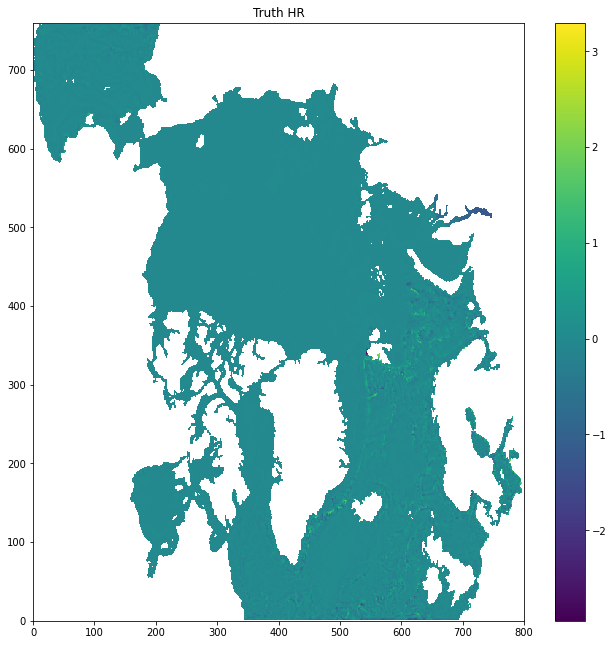

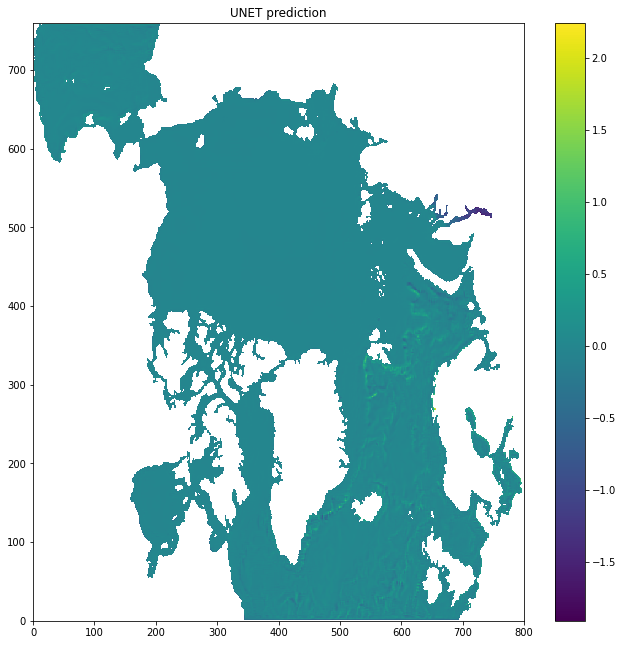

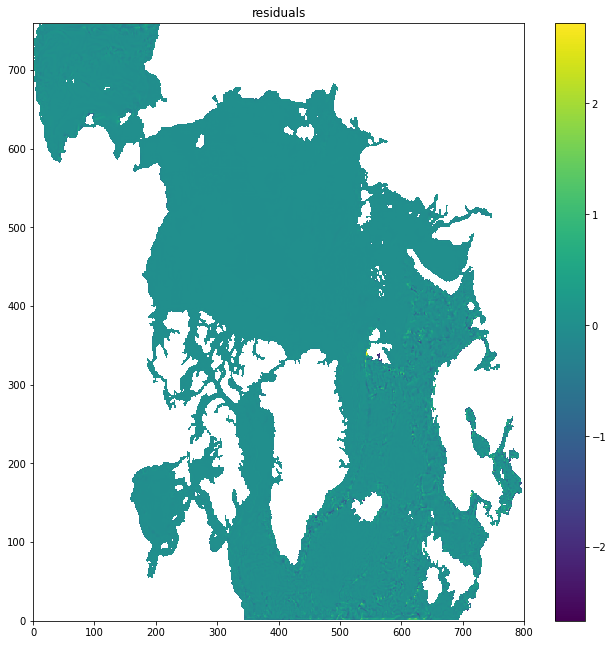

In [ ]:
plot_fld('Truth HR',y)
maxval = np.max(y)
minval = np.min(y)
plot_fld('UNET prediction',predict)

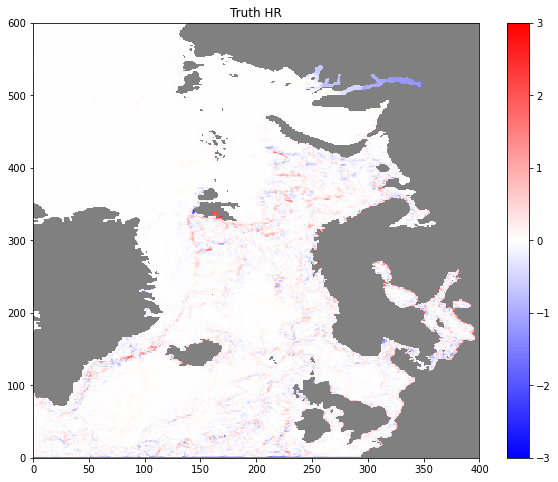

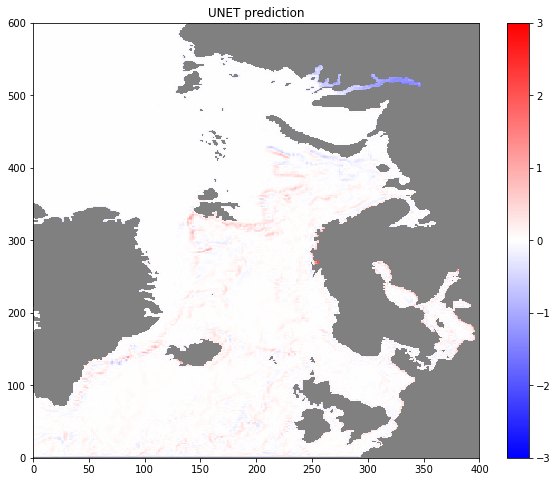

In [ ]:
plot_res('Truth HR', y[0:600,400:800], 3)
plot_res('UNET prediction', predict[0:600,400:800], 3) #np.max(y), np.min(y))

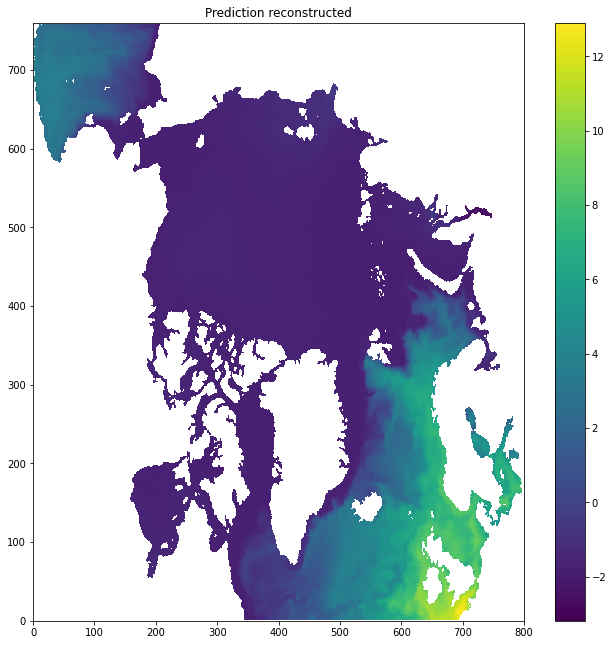

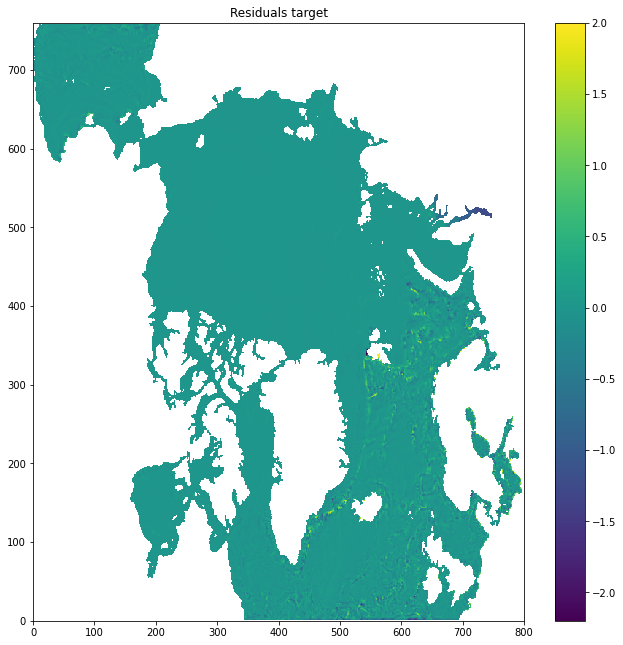

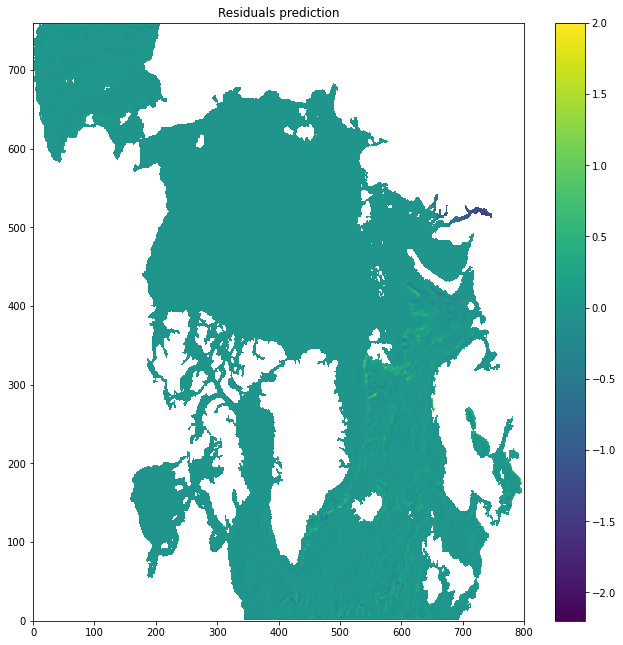

In [ ]:
plot_fld('Prediction reconstructed',prediction_reconstructed)
plot_fld('Residuals target', y, -2, 2)#, 2.5, -4)
plot_fld('Residuals prediction', predict, -2, 2)#, 2.5, -4)

## Errors comparison with Bilinear interpolation (baseline)

mse upsample 0.02444275621981621
mse unet 0.015664951161899452
mae upsample 0.06247677129175146
mae unet 0.05656752551329172


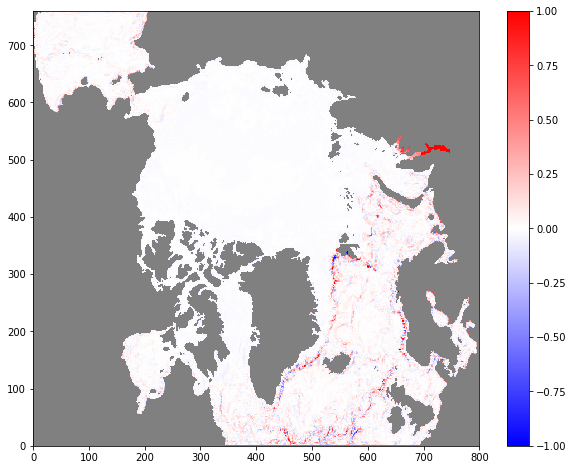

In [ ]:
# Compute bias
bias = np.mean(y) - np.mean(predict)
print('Bias:', bias)

# Correlation coefficients
correlation_coefficient_prediction = np.corrcoef(prediction_reconstructed.flatten(), y.flatten())[0, 1]
correlation_coefficient_bilinear = np.corrcoef(X.flatten(), y.flatten())[0, 1]
print("Correlation Coefficient between prediction and truth:")
print(correlation_coefficient_prediction)
print("Correlation Coefficient between Bilinear interpolation and truth:")
print(correlation_coefficient_bilinear)

# MSE
mse_upsample = np.mean(np.square(y)) # truth - LR_upsampled = truth - X = y
mse_unet = np.mean(np.square(y - predict)) # truth - prediction_reconstructed = y + X - (pred + X) = y - pred
print('mse upsample', mse_upsample)
print('mse unet', mse_unet)

# Peak Signal to Noise Ration
psnr_upsample = 10*np.log(255**2/mse_upsample)
psnr_unet = 10*np.log(255**2/mse_unet)
print('psnr upsample', psnr_upsample)
print('psnr unet', psnr_unet)

# MAE on unnormalized images
mae_upsample = np.mean(np.abs(y))
mae_unet = np.mean(np.abs(y - predict))
print('mae upsample', mae_upsample)
print('mae unet', mae_unet)

#RMSE MAP
RMSE_MAP_upsample = np.sqrt(np.square(y))
RMSE_MAP_unet = np.sqrt(np.square(y - predict))
RMSE_MAP = RMSE_MAP_upsample - RMSE_MAP_unet
plot_res('',RMSE_MAP,1)

In [ ]:
# SSIM loss (requires to get the normalized images)


# Get the normalized images
target_no = 0
target_name, target_layer = extract_name_and_number(list_targets[target_no])
target_layer = int(target_layer)
predict = predict_batch[0,:,:,target_no]
predict = predict[0:760,:]
X_batch, y_batch = test_generator[0] ## True data
X = X_batch[0,...,target_no] ## first 0 -> sample number in the batch ... last 0 -> predictor number
y = y_batch[0,...,target_no]
X = X[0:760,:]
y = y[0:760,:]

# Impose masks
tp5mask = np.load(os.path.join(paths["data_residuals"],'tp5mask.npy') )
y = np.ma.masked_array(y,tp5mask)
predict = np.ma.masked_array(predict,tp5mask)
X = np.ma.masked_array(X,tp5mask)

truth = y + X
prediction_reconstructed = predict + X

# Turn into tf.tensor and add a 3rd dimension to use the tf.ssim function
# NB: WHEN CONVERTING A MASK ARRAY TO TF_TENSOR, THE MASK BECOME 0
tf_truth = tf.convert_to_tensor(truth, dtype=tf.float32)
tf_prediction_reconstructed = tf.convert_to_tensor(prediction_reconstructed, dtype=tf.float32)
tf_X = tf.convert_to_tensor(X, dtype=tf.float32)

tf_truth = tf_truth[..., tf.newaxis]
tf_prediction_reconstructed = tf_prediction_reconstructed[..., tf.newaxis]
tf_X = tf_X[..., tf.newaxis]

ssim_upsample = tf.image.ssim_multiscale(tf_truth, tf_X, max_val=1.0)
ssim_unet = tf.image.ssim_multiscale(tf_truth, tf_prediction_reconstructed, max_val=1.0)
print('ssim upsample', ssim_upsample)
print('ssim unet', ssim_unet)

ssim upsample tf.Tensor(0.6325834, shape=(), dtype=float32)
ssim unet tf.Tensor(0.5345319, shape=(), dtype=float32)
mse upsample 0.2039894662810027
mse unet 1.6158485235881708e-05
mae upsample 0.4516231430746874
mae unet 0.001852359560623984


##### Mean for all Test images

In [ ]:
predict_all = unet_model.predict(test_generator) #test_generator['batch_number'][number of the sample in the batch']
predict = predict_all[:,0:-8,:,:]
print(predict_all.shape)
print(predict.shape)

(52, 768, 800, 1)
(52, 760, 800, 1)


###### RMSE

In [ ]:
total_mse_upsampled = np.zeros(len(list_targets))
total_mse_prediction = np.zeros(len(list_targets))
total_rrmse_upsampled = np.zeros(len(list_targets))
total_rrmse_prediction = np.zeros(len(list_targets))
batch_size = model_params["batch_size"]
filenames = test_generator.get_filenames()

for target_number in range (len(list_targets)):
    # Get the field name and layer number for denormalization
    name, number = extract_name_and_number(list_targets[target_number])
    number = int(number)
    #print(name,number)

    for i in range(len(test_generator)): # for each batch
        # Extract X and Y from the tuple
        X_i, Y_i = test_generator[i]
        predict_batch = unet_model.predict(test_generator[i][0])

        for sample_j in range(batch_size): # for each sample in batch i
            X_ij = X_i[sample_j, 0:-8, :, target_number]
            Y_ij = Y_i[sample_j, 0:-8, :, target_number]

            X_ij = denormalize(standard_LR_upsampled, name, number, X_ij)
            X_ij = np.ma.masked_array(X_ij,tp5mask)

            Y_ij = denormalize(standard_res, name, number, Y_ij)
            Y_ij = np.ma.masked_array(Y_ij,tp5mask)

            truth_ij = Y_ij + X_ij

            predict_ij = predict_batch[sample_j,0:-8,:,target_number]
            #predict_ij = predict[batch_size*i + sample_j,:,:,target_number]
            predict_ij = denormalize(standard_res, name, number, predict_ij)
            predict_ij = np.ma.masked_array(predict_ij,tp5mask)

            predict_reconstructed_ij = predict_ij + X_ij

            mse_upsampled = np.mean((Y_ij)**2)
            mse_prediction = np.mean((truth_ij - predict_reconstructed_ij)**2)

            rrmse_upsampled = np.sqrt( np.mean((Y_ij)**2)/np.sum(np.square(X_ij)) )
            rrmse_prediction = np.sqrt(np.mean((truth_ij - predict_reconstructed_ij)**2)/np.sum(np.square(predict_reconstructed_ij)))

            total_mse_upsampled[target_number] += mse_upsampled
            total_mse_prediction[target_number] += mse_prediction

            total_rrmse_upsampled[target_number] += rrmse_upsampled
            total_rrmse_prediction[target_number] += rrmse_prediction

mean_mse_upsampled = total_mse_upsampled / len(dates_test) # divide by the number of dates in the test set
mean_mse_prediction = total_mse_prediction / len(dates_test) # divide by the number of dates in the test set

print(f'MSE of all LR_upsampled values: {mean_mse_upsampled}')
print(f'MSE of all predicted values: {mean_mse_prediction}')

mean_rrmse_upsampled = total_rrmse_upsampled / len(dates_test)
mean_rrmse_prediction = total_rrmse_prediction / len(dates_test)

print(f'RRMSE of all LR_upsampled values: {mean_rrmse_upsampled}')
print(f'RRMSE of all predicted values: {mean_rrmse_prediction}')

MSE of all LR_upsampled values: [0.05902528]
MSE of all predicted values: [0.0352215]
RRMSE of all LR_upsampled values: [9.18545277e-05]
RRMSE of all predicted values: [7.14352167e-05]


###### SSIM

In [ ]:
total_ssim_upsampled = np.zeros(len(list_targets))
total_ssim_prediction = np.zeros(len(list_targets))

batch_size = model_params["batch_size"]
filenames = test_generator.get_filenames()

for target_number in range (len(list_targets)):
    # Get the field name and layer number for denormalization
    name, number = extract_name_and_number(list_targets[target_number])
    number = int(number)
    #print(name,number)

    for i in range(len(test_generator)): # for each batch
        # Extract X and Y from the tuple
        X_i, Y_i = test_generator[i]
        predict_batch = unet_model.predict(test_generator[i][0])

        for sample_j in range(batch_size): # for each sample in batch i
            X_ij = X_i[sample_j, 0:-8, :, target_number]
            Y_ij = Y_i[sample_j, 0:-8, :, target_number]

            X_ij = np.ma.masked_array(X_ij,tp5mask)
            Y_ij = np.ma.masked_array(Y_ij,tp5mask)
            truth_ij = Y_ij + X_ij

            tf_Xij = tf.convert_to_tensor(X_ij, dtype=tf.float32)
            tf_Xij = tf_Xij[..., tf.newaxis]

            tf_truth = tf.convert_to_tensor(truth_ij, dtype=tf.float32)
            tf_truth = tf_truth[..., tf.newaxis]

            predict_ij = predict_batch[sample_j,0:-8,:,target_number]
            predict_ij = np.ma.masked_array(predict_ij,tp5mask)

            predict_reconstructed_ij = predict_ij + X_ij
            tf_prediction_reconstructed = tf.convert_to_tensor(predict_reconstructed_ij, dtype=tf.float32)
            tf_prediction_reconstructed = tf_prediction_reconstructed[..., tf.newaxis]

            ssim_upsample = tf.image.ssim_multiscale(tf_truth, tf_Xij, max_val=1.0)
            ssim_unet = tf.image.ssim_multiscale(tf_truth, tf_prediction_reconstructed, max_val=1.0)

            total_ssim_upsampled[target_number] += ssim_upsample
            total_ssim_prediction[target_number] += ssim_unet

mean_ssim_upsampled = total_ssim_upsampled / len(dates_test) # divide by the number of dates in the test set
mean_ssim_prediction = total_ssim_prediction / len(dates_test) # divide by the number of dates in the test set

print(f'Mean of SSIM of all LR_upsampled values: {mean_ssim_upsampled}')
print(f'Mean of SSIM of all predicted values: {mean_ssim_prediction}')

Mean of SSIM of all LR_upsampled values: [0.66746807]
Mean of SSIM of all predicted values: [0.52860509]


## Spectral Power

In [ ]:
import scipy.stats as stats

def power_spectrum(xx):
    """
    https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    """

    ny,nx = xx.shape

    npix = min(nx, ny)
    fourier_image = np.fft.fftn(xx)
    fourier_amplitudes = np.abs(fourier_image)**2
    #By default, the wave vectors are given as a fraction of 1, by multiplying with the total number of pixels, we convert them to a pixel frequency.
    kfreqx = np.fft.fftfreq(nx) * nx
    kfreqy = np.fft.fftfreq(ny) * ny
    kfreq2D = np.meshgrid(kfreqy,kfreqx)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm=knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    #fourier_amplitudes=fourier_amplitudes.reshape(n,-1)
    #fourier_amplitudes_mean = np.mean(fourier_amplitudes,axis=0)
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic ="mean",
                                     bins = kbins)
    #Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
    #Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

white_noise = tf.random.normal(shape=(400,400))

In [ ]:
#HRtmp = abfile.ABFileRestart('/mnt/redda-ns2993k/Antoine/Betzy/data/HR/restart.1995_036_00_0000.a',"r",idm=800,jdm=760)
#LRtmp = abfile.ABFileRestart('/mnt/redda-ns2993k/Antoine/Betzy/data/LR/restart.1995_036_00_0000.a',"r",idm=400,jdm=380)
#fieldHR = HRtmp.read_field('temp',1,1)
#fieldLR = LRtmp.read_field('temp',1,1)

tp5mask = np.load('/mnt/redda-ns2993k/Antoine/Betzy/data/residuals/tp5mask.npy')
tp2mask = np.load('/mnt/redda-ns2993k/Antoine/Betzy/data/LR/tp2mask.npy')

from scipy.interpolate import RegularGridInterpolator
def downsample_array(original_array, target_shape=(380,400)):
    n_rows, n_cols = original_array.shape
    x = np.linspace(0, 759, n_rows)
    y = np.linspace(0, 799, n_cols)
    interp = RegularGridInterpolator((x, y), original_array, method='nearest', bounds_error=False, fill_value=None)
    x_new = np.linspace(0, 759, target_shape[0])
    y_new = np.linspace(0, 799, target_shape[1])
    xg_new, yg_new = np.meshgrid(x_new, y_new, indexing='ij')
    return interp((xg_new, yg_new))

from scipy.spatial import cKDTree
def downsampling(original_array):
    fieldData = original_array.copy()
    fieldData = fieldData.data
    fieldData[tp5mask] = np.nan
    fieldDS = downsample_array(fieldData)
    fieldDS[tp2mask] = 0
    nan_indices = np.isnan(fieldDS.data)
    coordinates = np.column_stack(np.where(np.logical_and(~tp2mask, ~nan_indices)))
    tree = cKDTree(coordinates)
    nearest_indices = tree.query(np.column_stack(np.where(nan_indices)))[1]
    nearest_values = fieldDS[coordinates[nearest_indices][:, 0], coordinates[nearest_indices][:, 1]]
    fieldDS[nan_indices] = nearest_values
    return fieldDS

NN_DS = downsampling(prediction_reconstructed)
fieldLR = downsampling(X)

In [ ]:
range_rowsHR = slice(210, 310)
range_colsHR = slice(515, 615)
range_rowsLR = slice(range_rowsHR.start // 2, range_rowsHR.stop // 2)
range_colsLR = slice(range_colsHR.start // 2, range_colsHR.stop // 2)

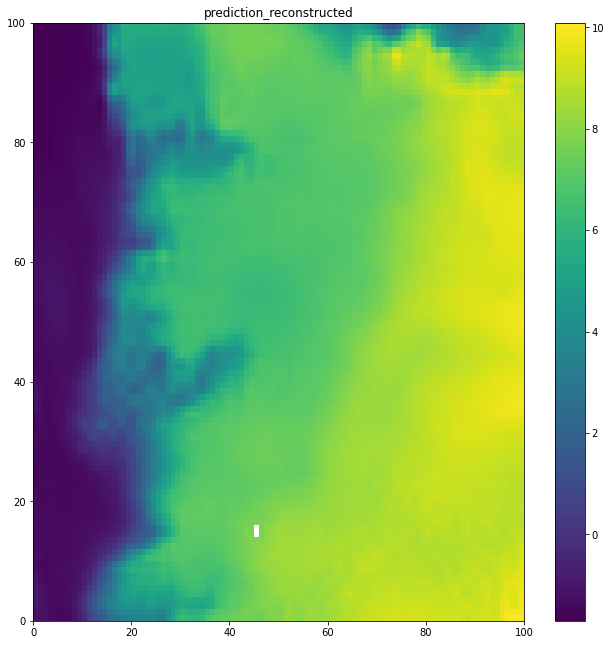

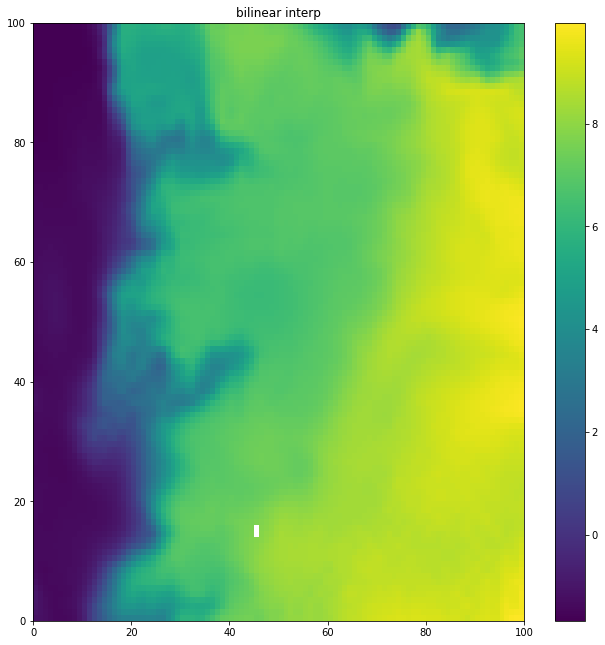

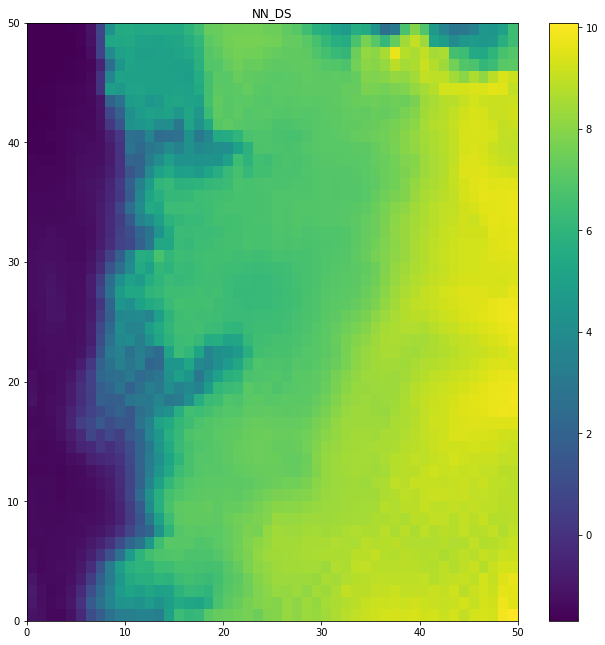

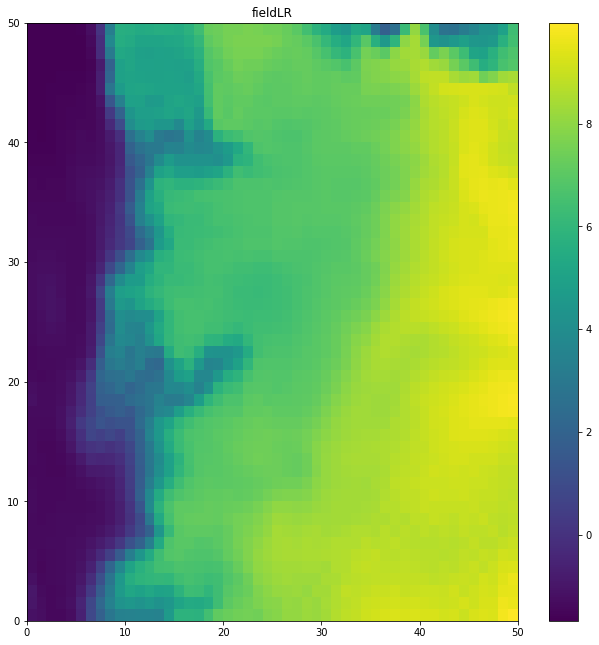

In [ ]:
plot_fld('prediction_reconstructed',prediction_reconstructed[range_rowsHR,range_colsHR])
plot_fld('bilinear interp',X[range_rowsHR,range_colsHR])
plot_fld('NN_DS',NN_DS[range_rowsLR,range_colsLR])
plot_fld('fieldLR',fieldLR[range_rowsLR,range_colsLR])
#plot_fld('',white_noise)

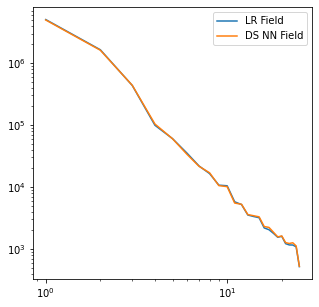

In [ ]:
#kwhite, Awhite = power_spectrum(white_noise[:400,:400])
klr, Alr = power_spectrum(fieldLR[range_rowsLR,range_colsLR])
kds, Ads = power_spectrum(NN_DS[range_rowsLR,range_colsLR])

fig, ax = plt.subplots(figsize=(5,5))

#ax.loglog(kwhite, Awhite)
ax.loglog(klr, Alr, label='LR Field')
ax.loglog(kds, Ads, label='DS NN Field')
ax.legend()

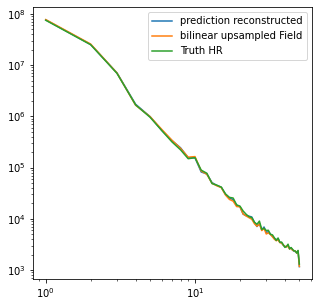

In [ ]:
khr, Ahr = power_spectrum(prediction_reconstructed[range_rowsHR,range_colsHR])
ktruth, Atruth = power_spectrum(Truth_reconstructed[range_rowsHR,range_colsHR])
kbilinear, Abilinear = power_spectrum(X[range_rowsHR,range_colsHR])

fig, ax = plt.subplots(figsize=(5,5))

ax.loglog(khr, Ahr, label='prediction reconstructed')
ax.loglog(kbilinear, Abilinear, label='bilinear upsampled Field')
ax.loglog(ktruth, Atruth, label='Truth HR')
ax.legend()